# Estimating the precision of the Capilytics system Equal Error-Rate as a function of sample size

## Introduction

This interactive Python notebook has been created to demonstrate the Capilytics team's calculations of necessary sample size for the forthcoming full service deployment study (ACERS IRAS324900), due to start in October 2025.

The Capilytics system computes an SSc score for each patient, which can be interpreted as an estimation of their probability of having SSc. One measure to evaluate these scores is to compute a ROC curve of the set of scores for a sample of patients, against the known disease status of the patient (SSc = positive, negative otherwise). A primary outcome of the study is to estimate the equal error-rate (EER) of the system - the point at which specificity and sensitivity are equal in the ROC curve - to a precision of $\pm$ 3%, and thus the study needs to be powered with sufficient (but not excess) sample size to achieve this.

To determine an appropriate sample size, we use the SSc scores for 175 subjects collected in the previous study (which ran from 2019 to 2022 and is usually denoted **i4i 2019** within the team), to estimate how the precision of the EER varies with sample size.

The basic approach is to take bootstrap samples of the i4i 2019 data, compute the ROC and EER for each, and then empirically estimate confidence intervals for the EER by computing percentiles of the bootstrapped data.

## Details of the bootstrapping

- The original data had an approximately 1:1 ratio of positive:negative (78 SSc, 77 non-SSc)
- The full service deployment will recruit a mixture of walk-in patients with primary Raynaud's phenomenon (2/3rds of the total subjects, of whom we expect < 1% will have SSc) and patients with known SSc (1/3rd of the total samples). Ignoring the former as providing negligible cases of SSc to the total sample, we thus expect a ratio of 1:2 positive:negative
- Thus to obtain a suitable bootstrap sample of size $N$ from the 175 i4i 2019 subjects we:
   1. Sample $N_{pos}$ from a Binomial distribution $(N, p=\frac{1}{3})$
   2. Take $N_{neg} = N - N_{pos}$
   3. Sample, without replacement, $N_{pos}$ and $N_{neg}$ from the positive and negative subjects respectively
- We compute ROC and EERs for 10,000 bootstrap samples per sample size
- We use sample sizes $N = [90, 120, 150, 180, 210, 240, 270, 300, 330, 360]$.
- Note sample sizes above 120 require oversampling negatives, and over 240 require oversampling both positives and negatives (which is not usually desirable in a bootstrap sample)
- An alternative method of projecting EER precision from a sample size of 120 is discussed below.

## Analytical estimation of sensitivity and specificity

In addition to directly estimating the precision of the EER from the bootstrapped data, we can also make analytic estimations of sensitivity and specificity, for any given value of $N_{pos}$ and $N_{neg}$, by assuming that the number of true positives $N_{TP}$ (or negatives $N_{TN}$) is a Binomial variable $(N_{pos}, p)$, where $p = 0.91$ is our estimate of the median EER. $N_{TP}$ thus has expected value $p N_{pos}$ and variance $p (1 - p) N_{pos}$. With the further assumption that for sufficiently large samples $N_{pos}$ is well approximated by a Gaussian, we can compute 5th and 95th confidence intervals about $N_{TP}$ by adding/subtracting $1.645 . \sqrt{ p (1 - p) N_{pos} }$. We can turn this into a sensitivity ($=\frac{N_{TP}}{N_{pos}}$) by dividing through by $N_{pos}$. So our final estimate for the 5th and 95th confidence intervals of sensitivity is:

- $  \text{Sens} = p \pm  1.645 \times \frac {\sqrt{ p (1 - p) N_{pos} }} {N_{pos}}  $

We can generate similar estimations for specificity ($=\frac{N_{TN}}{N_{neg}}$) swapping $N_{neg}$ for $N_{pos}$. However, it is important to note that this may underestimate the precision of the EER as it does not properly take into account the interaction between SSc-scores, true positives and false positives for a given sample.

## Projecting EER precision

From the analytical calculations above we can see that as sample size $N$ varies, there is an $\frac{\sqrt{N}}{N}$ scaling on the width of the confidence intervals. This gives a third, mixed, method for estimating EER precision for sample sizes greater than the original i4i 2019 data: we take the confidence interval for a given sample size (*eg* the size closest to our original data, in this case 120, when accounting for the change in positive/negative ratio), then project the width of this interval to other sample sizes by scaling by the ratio $\sqrt{ \frac{N_i}{N} }$ where $N_i$ is the base sample size and $N_i$ is the projected sample size.

## Experiments

The code below uses the three methods above to estimate confidence intervals for EER for sample sizes:

- $N = [90, 120, 150, 180, 210, 240, 270, 300, 330, 360]$

We generate the following plots:

- ROC curve heatmaps using the bootstrap samples, in which centiles of confidence intervals (CI) are shown by colour. These are overlaid with lines for the 5th and 95th CIs, with the line of equal-error and its intersection with the 5th and 95th CIs also shown. Plots are shown for samples sizes of 90, 150 and 300, showing how the width of the CIs reduce as sample size increases. These plots also highlight the point that the EER place tighter bounds on the sensitivity/specificity, than if the two are allowed to vary independently.

- Estimates of median and 5th and 95th CIs for the EER of each sample size from:
   1. Direct bootstrap sampling
   2. Projecting the 5th and 95th CI from a base of 120 samples to other sample sizes using the square-root ratio scaling
   3. Analytical estimations of sensitivity and specificity using Binomial and Gaussian assumptions on the variables

## Conclusions

The plot of estimated EER precision shows that:

- The bootstrapped 5th CI of EER closely follows the theoretical scaling on sample size.

- The bootstrapped estimates show that achieving the target precision of ±3% requires a sample size of around 300 (100 SSc, 200 not-SSc). This translates to whole-number recruitment targets for each of seven sites of 15 SSc, 30 not-SSc (105 SSc, 210 not-SSc, 315 in total).

- Analytic estimations of specificity and especially sensitivity likely overestimate the width of confidence intervals, most likely because the do not take into account the interactions between the distribution of SSc-scores and each other (*ie* the count of true positive and negative cases in a given sample can *not* be assumed to be independent Binomial variables).

To check the sample size of 315, we compute a set of bootstraps at this value, and recompute the ROC centiles plot, as shown in the final figure.  

Overall, we believe these experiments provide sufficient evidence to justify a target sample size of 315 subjects (15 SSc, 30 non-SSc at each of 7 centres) in the full service deployment study of the Capilytics system.



In [ ]:
'''
Requirements:

This iPython Jupyter notebook has been computed using versions:

python 3.11.11
ipython 8.31.0
numpy 1.26.4
matplotlib 3.10.0

It has not been tested with other versions of the above libraries, however
the modules used are all well-established so we do not expect any variability
if other recent versions of python, numpy or matplotlib are used instead.

'''

#---------------------------------------------------------
#Imports
from pathlib import Path
from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap

#---------------------------------------------------------
#Local functions

#---------------------------------------------------------
def  calculate_roc_curve(
        class_vals:np.ndarray,
        class_labels:np.ndarray,
        operating_pts:np.ndarray = None)->tuple[np.ndarray,float,np.ndarray,np.ndarray,float]:
    '''Compute the points on an ROC curve for a set of input
    values and true class labels
    

    Inputs:
        class_vals- 1D vector of values assigned to each point (usually a probability, but
        not necessarily so)

        class_labels - 1D vector of class labels, either {1,0}

        operating_pts- Threshold values at which to calculate ROC points,
        for probabilities these will vary from 0 to 1, for other input
        values they should vary from min(class_vals) to max(class_vals)


    Outputs:
        roc_pts: array (x,y)-coordinates defining the ROC curve, shape (N,2)
        auc: area under the curve
        tp_count: number of true positives at each operating point
        fp_count: number of false positives at each operating point
        auc_se: estimate of standard error on the AUC value

    

    Parameters
    ----------
    class_vals : np.ndarray
        1D-array of values (usually a probability, but not necessarily so), shape (N,), dtype=float
    class_labels : np.ndarray
        1D-boolean array of class labels for each value, shape (N,), dtype=bool
    operating_pts : np.ndarray, optional
        1D-array of operating points at which to compute ROC points. If none, uses the sorted
        set of class_vals, which gives the maximum resolution to the curve for the given
        sample, by default None

    Returns
    -------
    tuple[np.ndarray,float,np.ndarray,np.ndarray,float]
        _description_
    '''

    if operating_pts is None:
        # Use sorted class values
        eps = np.finfo(float).eps
        operating_pts = np.zeros(class_vals.size + 2)
        operating_pts[0] = np.min(class_vals)-eps
        operating_pts[1:-1] = np.sort(class_vals)
        operating_pts[-1] = np.max(class_vals)+eps

    #make sure class_labels are logicals
    if class_labels.dtype != bool:
        class_labels = class_labels.astype(bool)


    #compute number of positive/negative labels
    n_tot = class_labels.size
    n_pos = np.sum(class_labels)
    n_neg = n_tot - n_pos

    #pre-allocate space for roc_pts
    n_pts = operating_pts.size
    tp_count = np.zeros(n_pts)
    fp_count = np.zeros(n_pts)

    #Sort thresholds from high to low
    operating_pts = np.sort(operating_pts)[::-1]

    #Pre-extract pos/neg vals
    pos_vals = class_vals[class_labels]
    neg_vals = class_vals[~class_labels]

    # Calculate ROC points at thresholds from 0 to 5
    for op in range(n_pts):

        th = operating_pts[op]

        #Compute true positives, and true positive fraction
        tp_count[op] = np.sum(pos_vals > th) #also FN = n_pos - TP


        #Compute false positives, and false positive fraction
        fp_count[op] = np.sum(neg_vals > th) #also TN = n_neg - FP

    #Set of points on ROC curve are the true positive fractions vs flase
    #positive fractions (see commented out code above)
    roc_pts = np.concatenate(
        (fp_count.reshape((-1,1))/n_neg, tp_count.reshape((-1,1))/n_pos), axis=1)

    auc = np.sum( (roc_pts[1:,0]-roc_pts[:-1,0]) * roc_pts[:-1,1]) + \
            0.5*np.sum( (roc_pts[1:,0]-roc_pts[:-1,0]) * (roc_pts[1:,1]-roc_pts[:-1,1]) )

    q2 = np.sum(
        (roc_pts[1:,0]-roc_pts[:-1,0]) *
        (roc_pts[:-1,1]**2 + roc_pts[:-1,1]*(roc_pts[1:,1]-roc_pts[:-1,1]) +
        (roc_pts[1:,1]-roc_pts[:-1,1])*(roc_pts[1:,1]-roc_pts[:-1,1])/3) )

    q1 = np.sum(
        (roc_pts[1:,1]-roc_pts[:-1,1]) *
        ((1-roc_pts[1:,0])**2 + (1-roc_pts[1:,0])*(roc_pts[1:,0]-roc_pts[:-1,0]) +
        (roc_pts[1:,0]-roc_pts[:-1,0])*(roc_pts[1:,0]-roc_pts[:-1,0])/3) )

    auc_se = np.sqrt( (auc*(1-auc) + (n_pos-1)*(q1-auc**2) + (n_neg-1)*(q2-auc**2)) /
        (n_neg*n_pos) )

    return roc_pts, auc, tp_count, fp_count, auc_se

# ------------------------------------------------------------------------
def write_rocs(results_dir:Path, n_samples:int, results:SimpleNamespace):
    '''Print ROC results to text file

    Parameters
    ----------
    results_dir : Path
        Output filepath
    n_samples: int
        Number of samples for these results
    results : SimpleNamespace
        Results object
    '''
    roc_all = np.concatenate(
        (
            results.roc_x.reshape(-1,1),
            results.roc_median.reshape(-1,1),
            results.roc_CIs
        ),
        axis = 1
    )
    np.savetxt(Path(results_dir) / f'n{n_samples}_rocs.txt', roc_all)

# ------------------------------------------------------------------------
def write_aucs(results_dir:Path, n_samples:int, results:SimpleNamespace):
    '''Print AUC results to text file

    Parameters
    ----------
    results_dir : Path
        Output filepath
    n_samples: int
        Number of samples for these results
    results : SimpleNamespace
        Results object
    '''
    auc_all = np.concatenate(
        (
            np.atleast_1d(results.auc_median),
            results.auc_CIs,
            np.atleast_1d(results.eer_median),
            results.eer_CIs
        )
    )
    np.savetxt(Path(results_dir) / f'n{n_samples}_rocs.txt', auc_all)

# ------------------------------------------------------------------------
def expand_preds(preds:np.ndarray)->np.ndarray:
    '''Expand predictions array to start and end at 0 and 1 respectively

    Parameters
    ----------
    preds : np.ndarray
        1-D array of predictions

    Returns
    -------
    np.ndarray
        Expanded predictions, where preds[0]=0.0 and preds[-1] = 1.0
    '''
    op_pts = np.concatenate((
        np.array([0.0]),
        preds,
        np.array([1.0])
    ))
    return op_pts

# ------------------------------------------------------------------------
def resample_roc(roc_pts:np.ndarray, roc_xi:np.ndarray, do_plot:bool = False)->np.ndarray:
    '''Resample ROC at set of fixed x-locations

    Parameters
    ----------
    roc_pts : np.ndarray
        2-D array of ROC (x,y) points, shape (N, 2)
    roc_xi : np.ndarray
        1-D array of x-pts to resample at, shape (N,)
    do_plot : bool, optional
        If True, plot the resampling, by default False

    Returns
    -------
    np.ndarray
        Resampled y-pts to match roc_xi
    '''
    #.
    
    #First we need to resample the ROC so it is unique in x. This
    #necessarily involves some smoothing, but is ok given we're averaging
    #over lots of boots.
    
    #Get set of unique x-locations on original ROC curve
    roc_x = roc_pts[:,0]
    roc_y = roc_pts[:,1]
    x_uni = np.unique(roc_x)
    n_uni = x_uni.size
    
    #Get matching y-pts. For x == 0, take the max y-value as this is the
    #start of the ROC curve. For all subsequent x-points, if there are
    #repeats in x, take the mean of the matching y-values. This effectively
    #draws a straight-line through the centre of the steps. Plot the output
    #of this def to see the effect
    y_uni = np.zeros(n_uni)
    y_uni[0] = np.max(roc_y[roc_x==0])
    for i_u in range(1,n_uni):
        y_uni[i_u] = np.mean(roc_y[roc_x == x_uni[i_u]])
    
    
    #Now linearly interpolate at the given x-pts
    roc_yi = np.interp(roc_xi, x_uni, y_uni)
    
    if do_plot:
        plt.figure()
        plt.plot(roc_x, roc_y, linewidth = 2, label = 'Original ROC')
        plt.plot(x_uni, y_uni, linewidth = 1.5, label = 'Resampled')
        plt.plot(roc_xi, roc_yi, '--', linewidth = 1.5, label = 'Interpolated')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.axis('equal')
        plt.legend()

    return roc_yi

# ------------------------------------------------------------------------
#Compute the euqal error rate from a set of ROC pts. We'll do this a simple
#interpolation of the curve where it crosses the equal error line
def compute_eer(roc_pts:np.ndarray)->float:
    '''Compute the equal error rate from a set of ROC pts, by
        interpolating the curve where it crosses the equal error line

    Parameters
    ----------
    roc_pts : np.ndarray
        2-D array of ROC (x,y) points, shape (N, 2)

    Returns
    -------
    float
        Equal error rate
    '''
    
    #Convert ROC to specificity and sensitivity
    spec = 1 - roc_pts[:,0]
    sens = roc_pts[:,1]
    
    #Find the first operating point where sensitivity is greater the spec
    eer_idx = np.nonzero(sens > spec)[0][0]

    #Compute the line (y = mx + c) connecting this operating point with 
    #the preceeding one. The eer is the solution to this line and x = y
    # So eer = c / (1 - m)
    x1 = spec[eer_idx-1]
    x2 = spec[eer_idx]

    y1 = sens[eer_idx-1]
    y2 = sens[eer_idx]

    xd = x2 - x1
    yd = y2 - y1

    #Need to check margin cases where the line is horizontal/vertical
    if xd == 0:
        eer = x1
    elif yd == 0:
        eer = y1
    else:
        #Otherwise compute gradient m and intersect c in the usual way
        #then solve for eer
        m = (x2 - x1) / (y2 - y1)
        c = y1 - m*x1
        eer = c / (1 - m)

    return eer

# ------------------------------------------------------------------------
#Take a bootstrap sample of a given size, compute the ROC and then the
#equal error rate for this sample
def bootstrap_eer_ratio(
        ssc_labels:np.ndarray,
        ssc_scores:np.ndarray,
        roc_x:np.ndarray,
        ssc_proportion:float,
        n_pos:int,
        n_neg:int,
        all_pos_idx:np.ndarray,
        all_neg_idx:np.ndarray,
        n_samples:int,
        op_pts:np.ndarray)->tuple[float,float,np.ndarray]:
    '''_summary_

    Parameters
    ----------
    ssc_scores : np.ndarray
        1D array of SSc scores, shape (N,), dtype=float
    ssc_labels : np.ndarray
        1D array of SSc labels, shape (N,), dtype=bool
    roc_x : np.ndarray
        Fixed set of ROC x-coordinates against which ROC y-coordinates will be resampled
    ssc_proportion : float, [0-1]
        Proportion of samples to be positive SSc
    n_pos : int
        Number of positives in ssc_labels (saves recomputing for each boot)
    n_neg : int
        Number of negative in ssc_labels (saves recomputing for each boot)
    all_pos_idx : np.ndarray
        Indexes of positives in ssc_labels (saves recomputing for each boot)
    all_neg_idx : np.ndarray
        Indexes of negatives in ssc_labels (saves recomputing for each boot)
    n_samples : int
        Size of each bootstrap sample
    op_pts : np.ndarray
        Operating points at which to compute ROC (note the final returned curve
        will be resampled to the fixed x-coordinates specified by roc_x, so
        that each bootstrapped ROC has the same x-coordinates)

    Returns
    -------
    tuple[float,float,np.ndarray]
        _description_
    '''

    n_sampled_pos = np.random.binomial(n_samples, ssc_proportion)
    n_sampled_neg = n_samples - n_sampled_pos

    sampled_pos_idx = all_pos_idx[np.random.randint(n_pos, size=n_sampled_pos)] 
    sampled_neg_idx = all_neg_idx[np.random.randint(n_neg, size=n_sampled_neg)]

    sample_idx = np.concatenate([sampled_pos_idx,sampled_neg_idx])
    
    roc_pts, auc = calculate_roc_curve(
        ssc_scores[sample_idx], ssc_labels[sample_idx], op_pts)[:2]
    eer = compute_eer(roc_pts)
    roc_y = resample_roc(roc_pts, roc_x, False)
    return auc, eer, roc_y

# ------------------------------------------------------------------------
#Run bootstrap samples for a given sample size
def run_bootstrap_ratio(
        ssc_labels:np.ndarray,
        ssc_scores:np.ndarray,
        n_boots:int,
        roc_x:np.ndarray,
        ssc_proportion:float,
        n_samples:int)->tuple[np.ndarray,np.ndarray,np.ndarray]:
    '''_summary_

    Parameters
    ----------
    ssc_scores : np.ndarray
        1D array of SSc scores, shape (N,), dtype=float
    ssc_labels : np.ndarray
        1D array of SSc labels, shape (N,), dtype=bool
    n_boots : int
        Number of bootstrap samples to run
    roc_x : np.ndarray
        Fixed set of ROC x-coordinates against which ROC y-coordinates will be resampled
    ssc_proportion : float, [0-1]
        Proportion of samples to be positive SSc
    n_samples : int
        Size of each bootstrap sample

    Returns
    -------
    tuple[np.ndarray,np.ndarray,np.ndarray]
        - Array of AUC values for each bootstrap sample, shape (N_boots,)
        - Array of EER values for each bootstrap sample, shape (N_boots,)
        - Array of ROC y-coordinates for each bootstrap sample, shape (N_pts,N_boots)
    '''
    aucs = np.zeros(n_boots)
    eers = np.zeros(n_boots)
    roc_y = np.zeros((roc_x.size, n_boots))

    n_pos = ssc_labels.sum()
    n_neg = ssc_labels.size - n_pos
    all_pos_idx = np.nonzero(ssc_labels)[0]
    all_neg_idx = np.nonzero(~ssc_labels)[0]
    op_pts = expand_preds(ssc_scores)


    for i_boot in range(n_boots):
        res = bootstrap_eer_ratio(
            ssc_labels, ssc_scores, roc_x, ssc_proportion,
            n_pos, n_neg, all_pos_idx, all_neg_idx, n_samples, op_pts)
        aucs[i_boot], eers[i_boot],roc_y[:,i_boot] = res

    return aucs, eers, roc_y

# ------------------------------------------------------------------------
def compute_bootstrap_ratio_ROCs(
        ssc_scores:np.ndarray,
        ssc_labels:np.ndarray,
        ssc_proportion:float,
        n_samples:int,
        save_roc_y:bool=False,
        results_dir:Path=None)->SimpleNamespace:
    '''Compute bootstrap ROC for given SSc-scores and labels, sampling the data
    to achieve a given proportion of positive SSc

    Parameters
    ----------
    ssc_scores : np.ndarray
        1D array of SSc scores, shape (N,), dtype=float
    ssc_labels : np.ndarray
        1D array of SSc labels, shape (N,), dtype=bool
    ssc_proportion : float, [0-1]
        Proportion of samples to be positive SSc
    n_samples : int
        Number of samples in each bootstrap set
    save_roc_y : bool, optional
        If True, save all the full ROC curve for each bootstrap sample, by default False
    results_dir : Path, optional
        Optional folder to save output stats and plots to, by default None

    Returns
    -------
    SimpleNamespace
        Structure of results with fields:

        - roc_x: set of fixed ROC x-coordinates for all curves, shape (N_pts,)
        - roc_y: set of matching ROC y-coordinates, per bootstrap sample  (N_pts,N_boots)

        - auc_median: median of the ROC AUC values
        - auc_CIs: [5th, 95th] percentiles of the AUC values

        - eer_median: median of the EER AUC values
        - eer_CIs: [5th, 95th] percentiles of the EER values

        - roc_median: median of the ROC y-coordinates (over the bootstrap samples axis)
        - roc_CIs: [5th, 95th] percentiles of the ROC y-coordinates (over the bootstrap samples axis)
    '''
    print('\n----------------------------------------------------')
    roc_x = np.linspace(0, 1, 100)
    n_boots = 10000

    results = dict()

    results = SimpleNamespace()
    print(
        f'Running {n_boots} bootstrap samples to compute confidence intervals')
    
    results.roc_orig = calculate_roc_curve(
        ssc_scores, ssc_labels, 
        expand_preds(ssc_scores))

    aucs, eers, roc_y = run_bootstrap_ratio(
        ssc_labels, ssc_scores, n_boots, roc_x, ssc_proportion, n_samples)

    results.roc_x = roc_x
    if save_roc_y:
        results.roc_y = roc_y

    results.auc_median = np.median(aucs)
    results.auc_CIs = np.percentile(aucs, [5, 95])

    results.eer_median = np.median(eers)
    results.eer_CIs = np.percentile(eers, [5, 95])

    results.roc_median = np.median(roc_y, axis=1)
    results.roc_CIs = np.swapaxes(np.percentile(roc_y, [5, 95], axis=1), 0, 1)

    if results_dir is not None: 
        write_rocs(results_dir, n_samples, results)
        write_aucs(results_dir, n_samples, results)
    
    return results

#---------------------------------------------------------
def plot_bootstrap_ROCs(
        bootstrap_rocs:SimpleNamespace,
        n_samples:int,
        colormap:str='plasma',
        results_dir:Path=None):
    '''_summary_

    Parameters
    ----------
    bootstrap_rocs : SimpleNamespace
        Results structure returned by compute_bootstrap_ratio_ROCs
    n_samples : int
        Number of samples in each bootstrap set
    colormap : str, optional
        Colormap used for centiles of the ROCs, by default 'plasma'
    results_dir : Path, optional
        Optional folder to save output stats and plots to, by default None
    '''

    base_cmap = colormaps[colormap]
    base_cmap_colors = base_cmap(np.linspace(0, 1, 128))
    CI_cmap_colors = np.concatenate([base_cmap_colors[::-1,:], base_cmap_colors], axis=0)
    CI_cmap = ListedColormap(CI_cmap_colors)

    # Take colors at regular intervals spanning the colormap.
    n_lines = 101
    pcts = np.linspace(0, 1, n_lines)
    fill_colors = CI_cmap(pcts)

    roc_x = bootstrap_rocs.roc_x
    roc_y = np.percentile(bootstrap_rocs.roc_y, np.linspace(0,100,n_lines), axis=1) 

    eer_cis = bootstrap_rocs.eer_CIs
    plt.figure(figsize = (14,12))

    for i in range(50):
        plt.fill_between(
            100*roc_x, 
            100*roc_y[i,:], 
            100*roc_y[i+1,:],
            color = fill_colors[i], alpha = 0.75)
        
        plt.fill_between(
            100*roc_x, 
            100*roc_y[-i,:], 
            100*roc_y[-(i+1),:],
            color = fill_colors[i], alpha = 0.75)

    eer_str = f'EER CI[5th, 95th] = [{int(100*eer_cis[0])}%, {int(100*eer_cis[1])}%]'
    plt.plot(100 - 100*eer_cis, 100*eer_cis, 'go', markersize=10, label=eer_str)
    plt.plot(100*roc_x, 100*roc_y[5,:], 'g', label='ROC 5th, 95th centile')
    plt.plot(100*roc_x, 100*roc_y[95,:], 'g')
    plt.plot([0,100],[100,0], 'k--', label = 'EER line')
    plt.xlabel('100 - specificity (%)', fontsize = 24)
    plt.ylabel('Sensitivity (%)', fontsize = 24)
    plt.axis((0,100,0,100))

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=20)
    plt.title(
        f'ROC confidence intervals centiles, n = {n_samples}', fontsize=24)

    mappable = plt.scatter(
        np.full(n_lines, -1), 100*pcts, s=30, c=100*pcts, cmap=CI_cmap)
    cbar = plt.colorbar(mappable)
    cbar.set_label('Centile', fontsize=16)
    cbar.ax.tick_params(labelsize=14) 

    if results_dir:
        plt.savefig(Path(results_dir) / f'bootstrap_rocs_n{n_samples}.png',
            bbox_inches='tight', facecolor='w')

#---------------------------------------------------------
def plot_bootstrap_EER_CIs(
        bootstrap_results:dict[int,SimpleNamespace],
        base_n:int,
        results_dir:Path=None):
    '''Plot estimates of EER precision using:
    1. The bootstrap samples results
    2. Analytics estimates of sensitivity/sepcificity
    3. Projections of EER from a base sample set using a sqrt(Ni/N) scaling

    Parameters
    ----------
    bootstrap_results : dict[int,SimpleNamespace]
        Set of bootstrap results structures as returned by compute_bootstrap_ratio_ROCs, one
        set of results per sample size
    base_n : int
        Sample size to use as the base set for projecting EER estimates
    results_dir : Path, optional
        Optional folder to save output stats and plots to, by default None
    '''
    
    p = bootstrap_results[base_n].eer_median
    q = 1.0 - p
    prev = 1 / 3
    z = 1.645
    x_min = 90
    x_max = 360

    full_sample_CIs = bootstrap_results[base_n].eer_CIs
    CI_projections_x = np.linspace(x_min, x_max, 100)
    CI_scaling = np.sqrt(base_n / CI_projections_x)
    CI_projections_y_5 = p - (p - full_sample_CIs[0])* CI_scaling
    CI_projections_y_95 = p - (p - full_sample_CIs[1])* CI_scaling
    
    label_set = False

    plt.figure()
    plt.plot([x_min, x_max], [100*p, 100*p], 'g--', label = '91% +/- 3%')
    plt.plot([x_min, x_max], [100*p + 3, 100*p + 3], 'g--')
    plt.plot([x_min, x_max], [100*p - 3, 100*p - 3], 'g--')
    for n_samples, res in bootstrap_results.items():
        
        npos = n_samples*prev
        nneg = n_samples-npos

        sens_std = np.sqrt(npos*p*q) / npos
        spec_std = np.sqrt(nneg*p*q) / nneg

        sens_5 = p - z*sens_std
        sens_95 = p + z*sens_std
        spec_5 = p - z*spec_std
        spec_95 = p + z*spec_std

        if label_set:
            plt.plot(n_samples, 100*res.eer_CIs[0], 'ko')
            plt.plot(n_samples, 100*res.eer_CIs[1], 'ko')
            plt.plot(n_samples, 100*res.eer_median, 'ks')
            plt.plot(n_samples, 100*sens_5, 'ro')
            plt.plot(n_samples, 100*sens_95, 'ro')
            plt.plot(n_samples, 100*spec_5, 'bo')
            plt.plot(n_samples, 100*spec_95, 'bo')
        else:
            label_set = True
            plt.plot(n_samples, 100*res.eer_CIs[0], 'ko', label='Bootstrapped EER CI[5th,95th]')
            plt.plot(n_samples, 100*res.eer_CIs[1], 'ko')
            plt.plot(n_samples, 100*res.eer_median, 'ks', label='Bootstrapped EER median')
            plt.plot(n_samples, 100*sens_5, 'ro', label='Analytic sens. CI[5th,95th]')
            plt.plot(n_samples, 100*sens_95, 'ro')
            plt.plot(n_samples, 100*spec_5, 'bo', label='Analytic spec. CI[5th,95th]')
            plt.plot(n_samples, 100*spec_95, 'bo')

    plt.plot(CI_projections_x, 100*CI_projections_y_5, 'c--', label='Projected CI[5th,95th]')
    plt.plot(CI_projections_x, 100*CI_projections_y_95, 'c--')

    plt.legend(loc='lower right')
    plt.ylim([75, 100])

    plt.xlabel('Sample size')
    plt.ylabel('EER %')
    plt.title('Estimating EER precision per sample size')

    if results_dir:
        plt.savefig(Path(results_dir) / 'estimating_EER_per_smaple_size.png',
            bbox_inches='tight', facecolor='w')

In [3]:
#Load data and run bootstrap samples
data_dir = ''
results_dir = None #Set to a path to save output

all_summary_metrics = np.loadtxt(Path(data_dir,'DinoLite_metrics.csv'), delimiter=',')
ssc_labels = all_summary_metrics[:,-1] > 0
bootstrap_results = {}

for n_samples in [90, 120, 150, 180, 210, 240, 270, 300, 330, 360]:
    bootstrap_results[n_samples] = compute_bootstrap_ratio_ROCs(
        ssc_scores=all_summary_metrics[:,5], 
        ssc_labels=ssc_labels, 
        ssc_proportion=1/3, 
        n_samples=n_samples, 
        save_roc_y=True, 
        results_dir=results_dir)




----------------------------------------------------
Running 10000 bootstrap samples to compute confidence intervals


C:\Users\momeemb2\AppData\Local\Temp\ipykernel_23688\4022051532.py:119: RuntimeWarning: invalid value encountered in sqrt
  auc_se = np.sqrt( (auc*(1-auc) + (n_pos-1)*(q1-auc**2) + (n_neg-1)*(q2-auc**2)) /



----------------------------------------------------
Running 10000 bootstrap samples to compute confidence intervals

----------------------------------------------------
Running 10000 bootstrap samples to compute confidence intervals

----------------------------------------------------
Running 10000 bootstrap samples to compute confidence intervals

----------------------------------------------------
Running 10000 bootstrap samples to compute confidence intervals

----------------------------------------------------
Running 10000 bootstrap samples to compute confidence intervals

----------------------------------------------------
Running 10000 bootstrap samples to compute confidence intervals

----------------------------------------------------
Running 10000 bootstrap samples to compute confidence intervals

----------------------------------------------------
Running 10000 bootstrap samples to compute confidence intervals

----------------------------------------------------
Ru

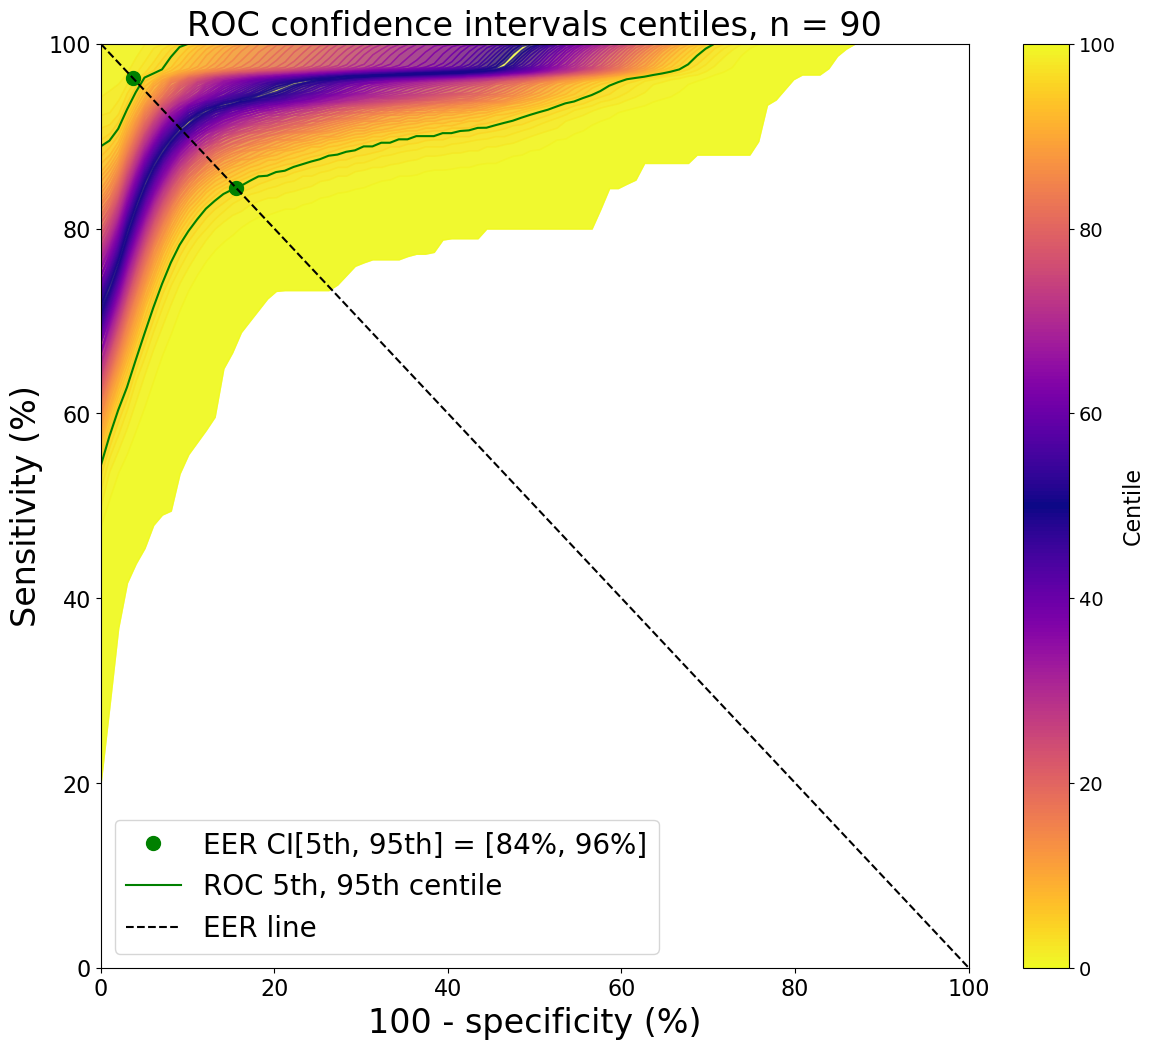

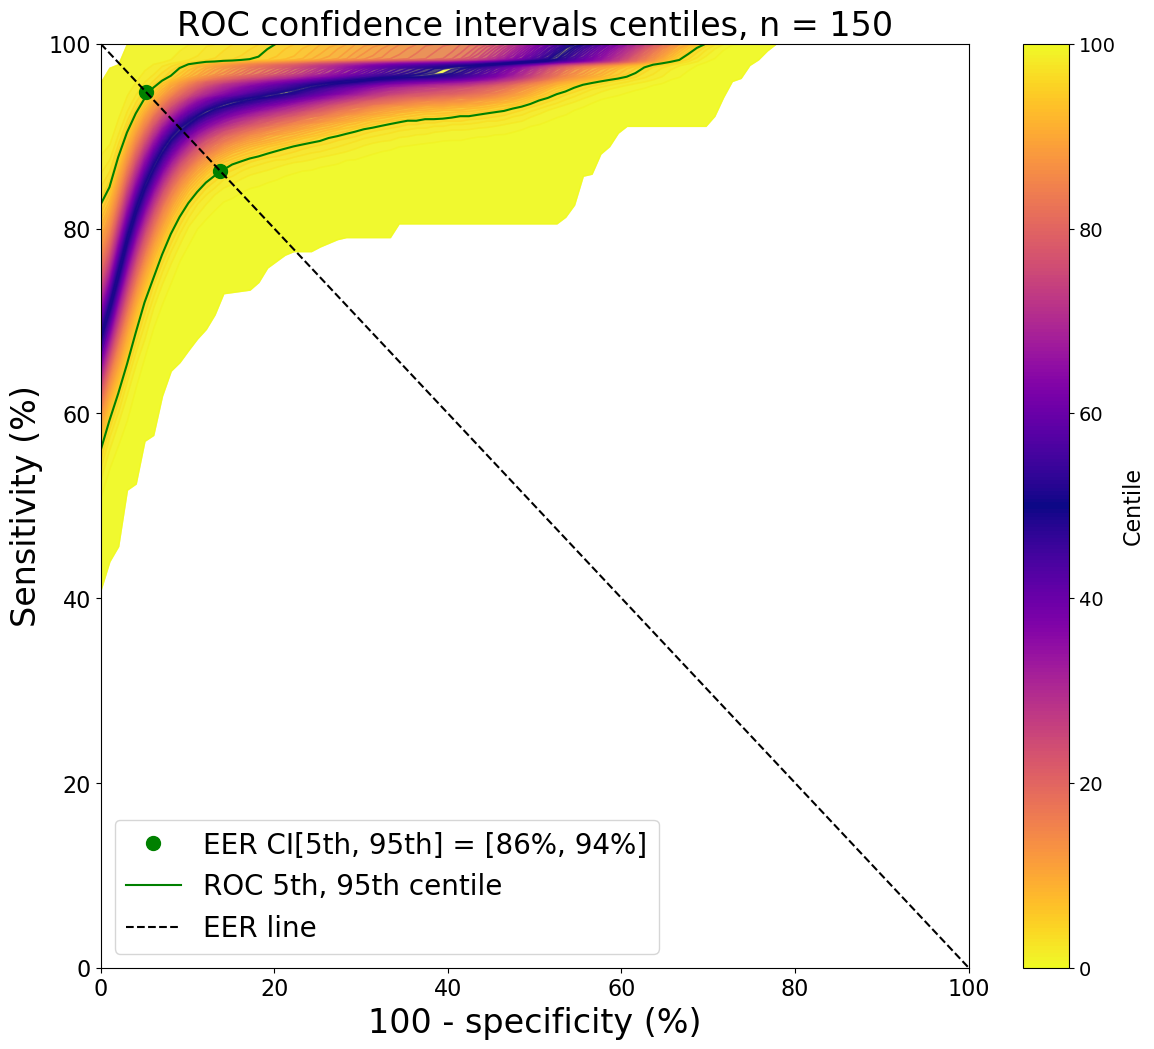

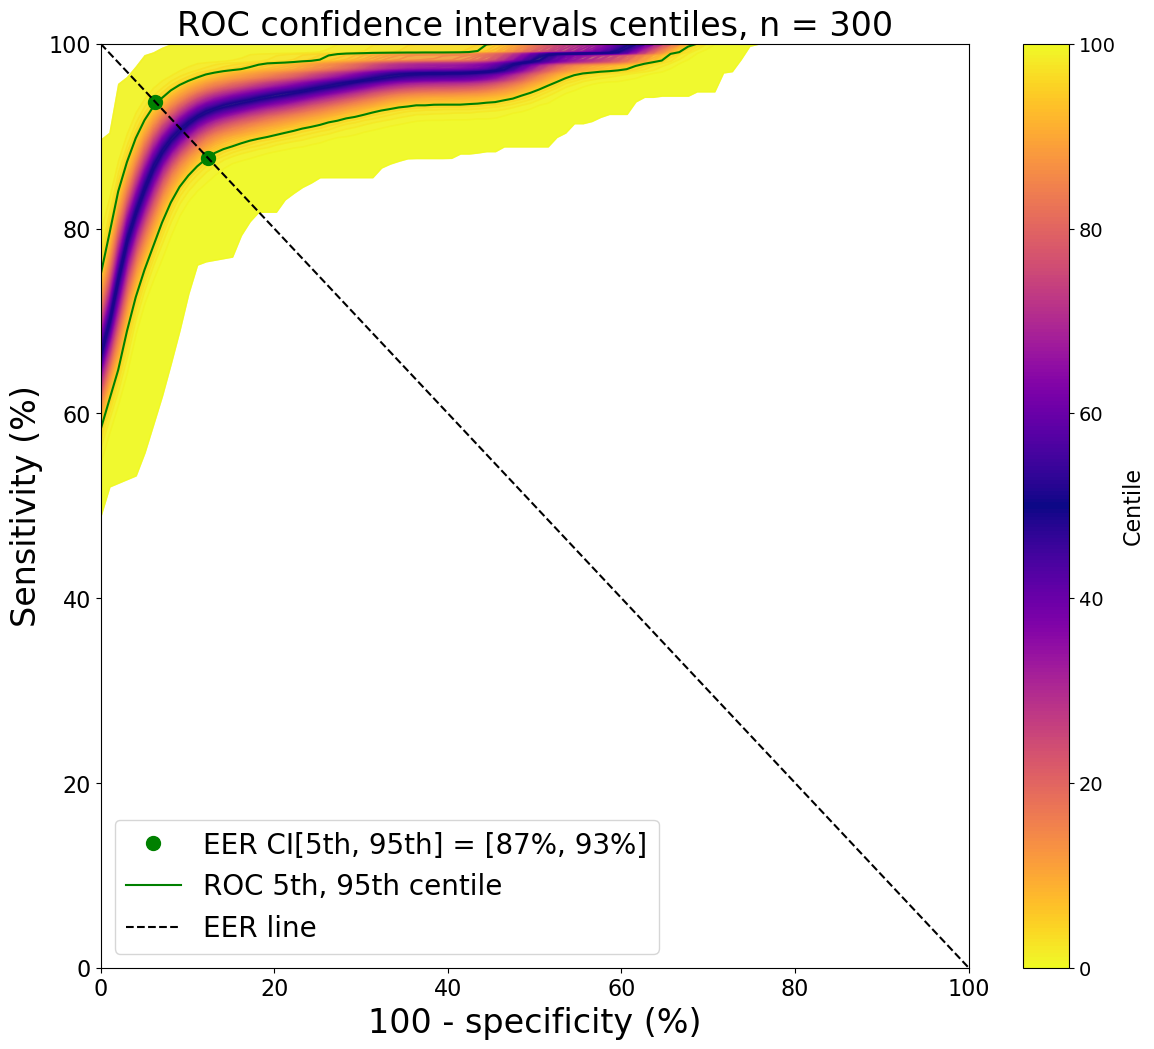

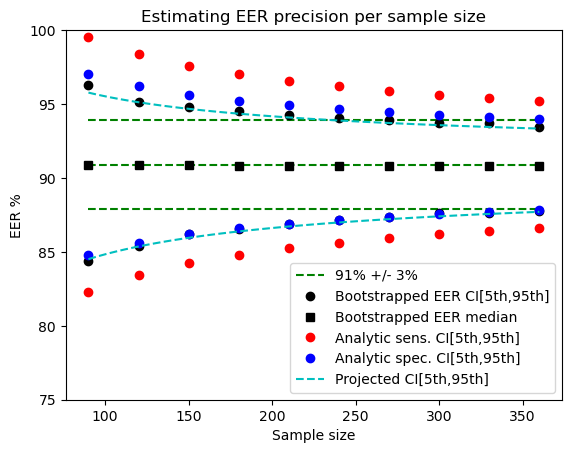

In [6]:
# Make plots of the bootstrap ROC centiles and precision estimates for EER
#---------------------------------------------------------
for sample_size in [90, 150, 300]:
    plot_bootstrap_ROCs(bootstrap_results[sample_size], sample_size)

plot_bootstrap_EER_CIs(bootstrap_results, 120, results_dir)


----------------------------------------------------
Running 10000 bootstrap samples to compute confidence intervals


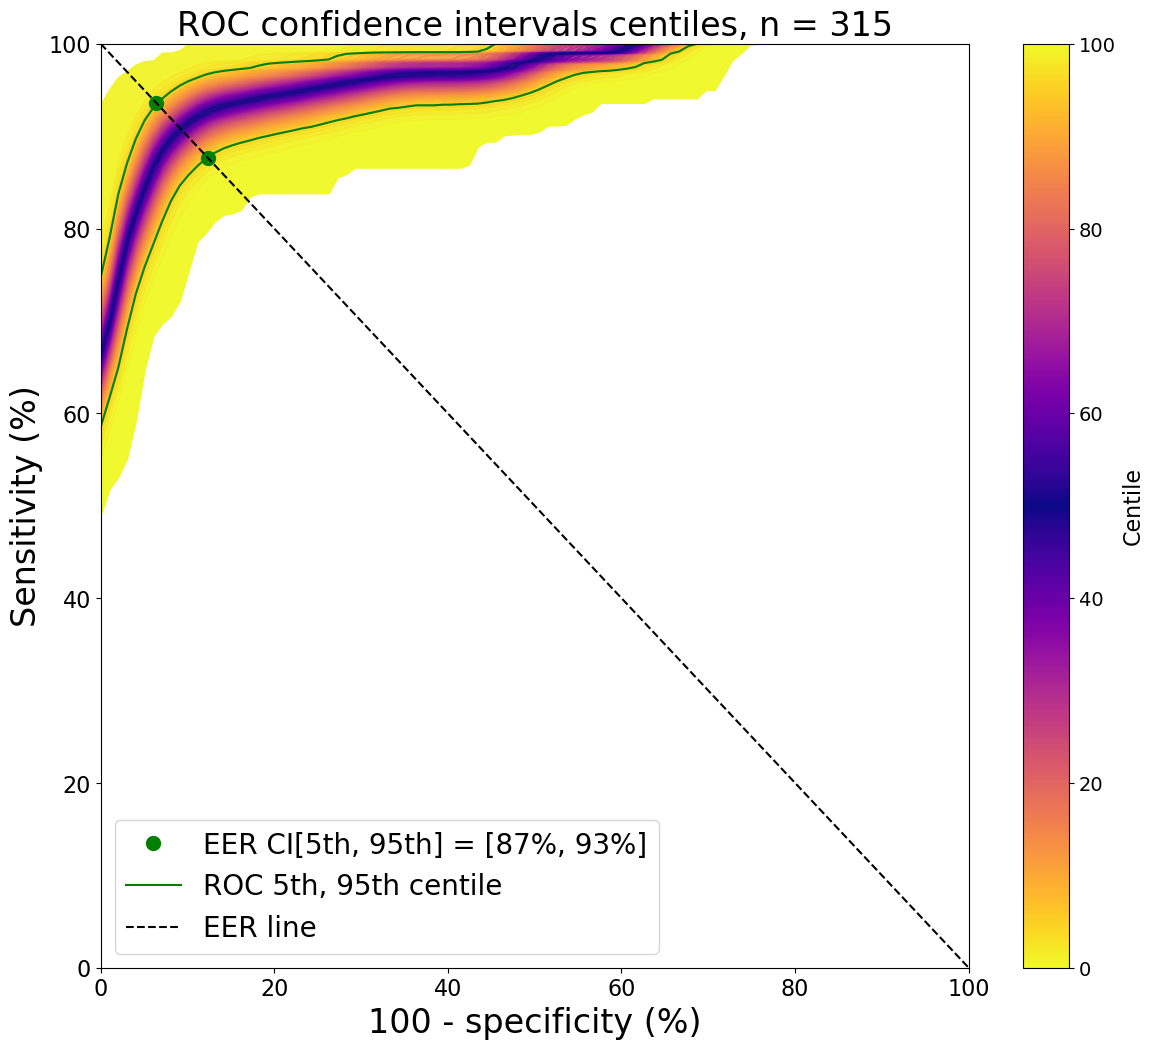

In [7]:
#Compute bootstrap samples for n=315 - the value obtained for a total sample size > 300,
# while using whole numbers of positives/negatives in a 1:2 ratio at each of 7 centres 
bootstrap_315 = compute_bootstrap_ratio_ROCs(
        ssc_scores=all_summary_metrics[:,5], 
        ssc_labels=ssc_labels, 
        ssc_proportion=1/3, 
        n_samples=315, 
        save_roc_y=True, 
        results_dir=results_dir)
plot_bootstrap_ROCs(bootstrap_315, 315)
